In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


In [10]:
DATA_DIR = "chest-dataset-enhanced"  # Ensure it has `train/` and `val/` subfolders
NUM_CLASSES = 7
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
# Load the full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Split into train and validation sets (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [12]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)


In [13]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [14]:
train_losses, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    print(f"\n🔁 Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # 🔍 Debug every 50 steps
        if (i + 1) % 50 == 0 or (i + 1) == len(train_loader):
            step_acc = 100 * correct / total
            print(f"📊 Step [{i+1}/{len(train_loader)}] | Loss: {loss.item():.4f} | Acc so far: {step_acc:.2f}%")

    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    print(f"✅ Train Loss: {epoch_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # 🔍 Validation
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    scheduler.step()

    print(f"🔎 Validation Accuracy: {val_acc:.2f}%")




🔁 Epoch 1/10
📊 Step [50/942] | Loss: 1.6194 | Acc so far: 35.50%
📊 Step [100/942] | Loss: 1.5843 | Acc so far: 37.88%
📊 Step [150/942] | Loss: 1.5691 | Acc so far: 38.23%
📊 Step [200/942] | Loss: 1.4732 | Acc so far: 39.58%
📊 Step [250/942] | Loss: 1.4573 | Acc so far: 40.59%
📊 Step [300/942] | Loss: 1.4711 | Acc so far: 41.75%
📊 Step [350/942] | Loss: 1.6033 | Acc so far: 42.69%
📊 Step [400/942] | Loss: 1.4025 | Acc so far: 43.26%
📊 Step [450/942] | Loss: 1.4439 | Acc so far: 43.69%
📊 Step [500/942] | Loss: 1.2802 | Acc so far: 44.16%
📊 Step [550/942] | Loss: 1.4656 | Acc so far: 44.44%
📊 Step [600/942] | Loss: 1.6858 | Acc so far: 44.83%
📊 Step [650/942] | Loss: 1.3379 | Acc so far: 45.02%
📊 Step [700/942] | Loss: 1.3690 | Acc so far: 45.54%
📊 Step [750/942] | Loss: 1.4672 | Acc so far: 45.89%
📊 Step [800/942] | Loss: 1.5422 | Acc so far: 46.15%
📊 Step [850/942] | Loss: 1.2009 | Acc so far: 46.57%
📊 Step [900/942] | Loss: 1.3828 | Acc so far: 46.76%
📊 Step [942/942] | Loss: 1.3211 |

In [16]:
torch.save(model.state_dict(), "resnet18_chest.pth")
print("✅ Model saved as resnet18_chest.pth")


✅ Model saved as resnet18_chest.pth


In [17]:
model.load_state_dict(torch.load("resnet18_chest.pth"))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat


📊 Classification Report
                    precision    recall  f1-score   support

       Atelectasis       0.78      0.72      0.75       957
          Effusion       0.80      0.81      0.81       990
      Infiltration       0.72      0.76      0.74       974
            Nodule       0.76      0.76      0.76      1017
Pleural_Thickening       0.85      0.88      0.87      1623
         Pneumonia       1.00      1.00      1.00      1003
      Pneumothorax       0.84      0.79      0.81       968

          accuracy                           0.82      7532
         macro avg       0.82      0.82      0.82      7532
      weighted avg       0.82      0.82      0.82      7532



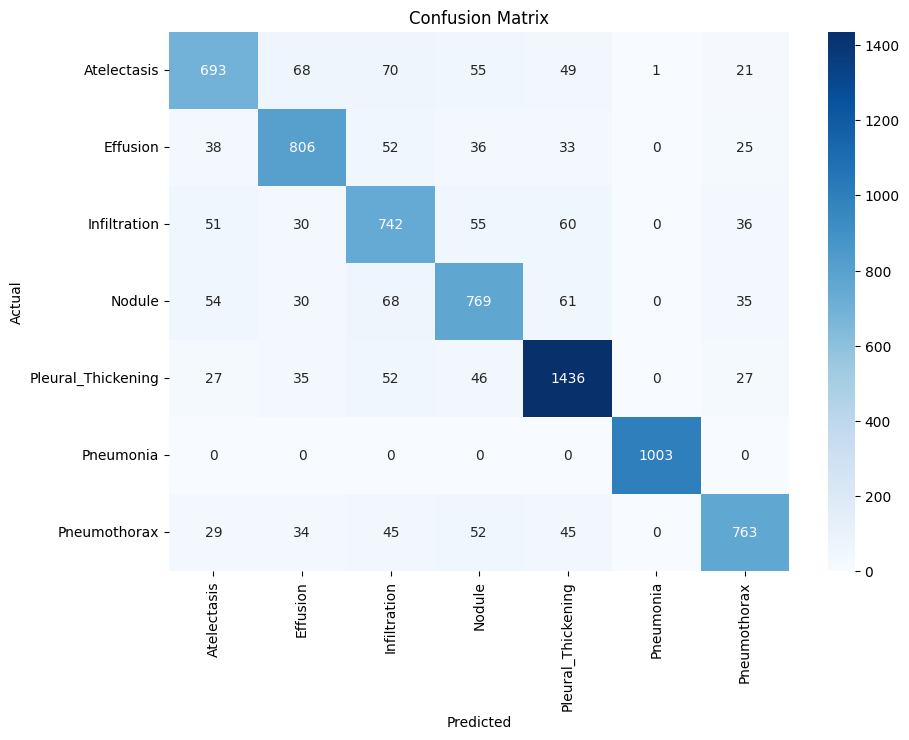

In [18]:
print("\n📊 Classification Report")
print(classification_report(all_labels, all_preds, target_names=val_dataset.dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=val_dataset.dataset.classes, 
            yticklabels=val_dataset.dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

